In [1]:
import numpy as np
import matplotlib.pylab as plt
import Vol6Utl as utl

## SGD

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## Momentum

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

## AdaGrad

In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key]*grads[key]
            params[key] -= self.lr * grads[key]/(np.sqrt(self.h[key]) + 1e-7)

## weight_init_activation_histogram

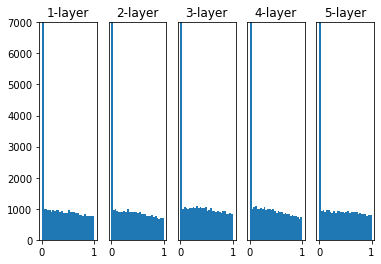

In [5]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    #z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


## MNISTによる比較

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from DLfromscratch.dataset.mnist import load_mnist

def smooth_curve(x):
    """損失関数のグラフを滑らかにするために用いる

    参考：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from collections import OrderedDict
from DLfromscratch.common.layers import *
from DLfromscratch.common.gradient import numerical_gradient


class MultiLayerNet:
    """全結合による多層ニューラルネットワーク

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        損失関数の値
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


## 過学習

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from DLfromscratch.dataset.mnist import load_mnist

In [8]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True) #Mnistダウンロード

In [9]:
## 過学習を再現するために、学習データを削減
#x_train = x_train[:300]
#t_train = t_train[:300]
#
## weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
##weight_decay_lambda = 0.1
## ====================================================
#
#network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
#                        weight_decay_lambda=weight_decay_lambda)
#optimizer = SGD(lr=0.01)
#
#max_epochs = 201
#train_size = x_train.shape[0]
#batch_size = 100
#
#train_loss_list = []
#train_acc_list = []
#test_acc_list = []
#
#iter_per_epoch = max(train_size / batch_size, 1)
#epoch_cnt = 0
#
#for i in range(1000000000):
#    batch_mask = np.random.choice(train_size, batch_size)
#    x_batch = x_train[batch_mask]
#    t_batch = t_train[batch_mask]
#
#    grads = network.gradient(x_batch, t_batch)
#    optimizer.update(network.params, grads)
#    
#    if i % iter_per_epoch == 0:
#        train_acc = network.accuracy(x_train, t_train)
#        test_acc = network.accuracy(x_test, t_test)
#        train_acc_list.append(train_acc)
#        test_acc_list.append(test_acc)
#
#        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))
#
#        epoch_cnt += 1
#        if epoch_cnt >= max_epochs:
#            break
#
## 3.グラフの描画==========
#markers = {'train': 'o', 'test': 's'}
#x = np.arange(max_epochs)
#plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
#plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
#plt.xlabel("epochs")
#plt.ylabel("accuracy")
#plt.ylim(0, 1.0)
#plt.legend(loc='lower right')
#plt.show()

## DropOut

In [10]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio #入力と同じサイズのマスクのarrayを生成
            return x * self.mask
        else:
            return x * (1. - self.dropout_ratio)
    
    def backward(self, dout):
        return dout*self.mask #maskでfalseとなっている要素は0に置き換わる(Reluと同じ)

In [11]:
mask = np.random.rand(*(2,3))>0.5
mask

array([[ True, False,  True],
       [False,  True, False]])

In [12]:
tmp=np.array([[1,2,3],
             [4,5,6]])
tmp*mask

array([[1, 0, 3],
       [0, 5, 0]])

# Convolution レイヤ

In [13]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


In [14]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None
    
    def forward(self, x, train_flg=True):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T #フィルタ展開
        
        #print(f"col.shape:{col.shape}")
        #print(f"col_W.shape:{col_W.shape}")
        
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        #フィルタ側
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        #イメージ側
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx
        

# Pooling レイヤの実装

In [15]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pool_h - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pool_w - FW) / self.stride)
        
        #展開(１)
        col = imcol(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        #最大値(２)
        arg_max = np.argmax(col, axis=1)#一番大きい値の位置を覚えておく
        out = np.max(col, axis=1)
        #整形(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max
        
        return out
    
    def backward(self, dout):
        #poolingの場合学習パラメータは存在しない。
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        #覚えておいたMAXの位置のみにdoutを返す。(他は0のまま)
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

# CNNモデル

In [16]:
class SimpleConvNet:
    def __init__(self, input_dim={1, 28, 28},
                conv_param={'filter_num':30, 'filter_size':5, 
                           'pad':0, 'stride':1},
                hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad)/filter_stride + 1
        pool_output_size = int(filter_num*(conv_output_size/2)*(conv_output_size/2))
        
        #重みパラメータ
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        #レイヤ
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                          self.params['b1'],
                                          conv_param['stride'],
                                          conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'],
                                       self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'],
                                       self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def gradient(self, x, t):
        #forward
        self.loss(x, t)
        
        #backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout - layer.backward(dout)
        
        #設定
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].dW
        
        return grads


In [17]:
from DLfromscratch.common.optimizer import *

class Trainer:
    """ニューラルネットの訓練を行うクラス
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimizer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprop':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


train loss:2.297891461868232
=== epoch:1, train acc:0.128, test acc:0.12 ===
train loss:2.29461747648177
train loss:2.294914527784889
train loss:2.286092434396578
train loss:2.2807524201633047
train loss:2.255168084697051
train loss:2.244673551759313
train loss:2.2462133658768515
train loss:2.2141917442037777
train loss:2.202938962958139
train loss:2.191116546526192
train loss:2.128235657955119
train loss:2.071529214522457
train loss:2.019848247169938
train loss:2.0062143687973357
train loss:1.9561035604702104
train loss:1.8564286061930746
train loss:1.8143170611866666
train loss:1.7919334083859888
train loss:1.6702845251560579
train loss:1.6196877291973386
train loss:1.459399065117604
train loss:1.465706324289978
train loss:1.3851367119492535
train loss:1.2502492594497054
train loss:1.181093233477177
train loss:1.219939055005517
train loss:1.0942129691269207
train loss:0.9973881291508856
train loss:0.8991315089442932
train loss:0.9179767581254298
train loss:0.8290435285269069
train lo

train loss:0.24832499613976022
train loss:0.2307863407832013
train loss:0.11132653213181096
train loss:0.41177993334360286
train loss:0.2047546284159647
train loss:0.25511087105558605
train loss:0.23138773082143976
train loss:0.24490473338499652
train loss:0.1468539033489074
train loss:0.21545657231664248
train loss:0.1669333538883908
train loss:0.37341769740771574
train loss:0.35414534416079674
train loss:0.12913903368767396
train loss:0.22197295161818847
train loss:0.21630829512286703
train loss:0.20237081076166547
train loss:0.2545011700099288
train loss:0.19462324295728448
train loss:0.13747433526338945
train loss:0.26746843803597836
train loss:0.1934785849363171
train loss:0.18884514048870812
train loss:0.16197720967696036
train loss:0.2028000228217718
train loss:0.13533230647227598
train loss:0.29958243291076353
train loss:0.16503992941634302
train loss:0.3850541090919945
train loss:0.22916742519518785
train loss:0.13460212949751119
train loss:0.17064756770722678
train loss:0.272

train loss:0.2227621519642598
train loss:0.21621355803077005
train loss:0.10406053018468231
train loss:0.07537320085272628
train loss:0.09790747321191173
train loss:0.07871384131370869
train loss:0.17988558267540855
train loss:0.11031053931807
train loss:0.13160041204336254
train loss:0.07998254159602931
train loss:0.184534535480861
train loss:0.11882397677223393
train loss:0.16250449600524905
train loss:0.0993206446857713
train loss:0.10146690109898224
train loss:0.09176371826918933
train loss:0.13695399944129136
train loss:0.14700137712599892
train loss:0.1368685696751112
train loss:0.07533070409356124
train loss:0.17827503230178074
train loss:0.0808603093898933
train loss:0.06464703891902043
train loss:0.20930038483640082
train loss:0.12660172268831676
train loss:0.18603125106077628
train loss:0.20043272650084665
train loss:0.13967959782531994
train loss:0.1338665787430659
train loss:0.10616029446525299
train loss:0.15326404240896965
train loss:0.15072424050919364
train loss:0.09985

train loss:0.072888828235283
train loss:0.10960245590253967
train loss:0.14211916252004855
train loss:0.1595171914253297
train loss:0.09935129280916973
train loss:0.10424015231668889
train loss:0.04600955152616953
train loss:0.11911120937365287
train loss:0.15417545623841927
train loss:0.06416209151366514
train loss:0.08355710178030584
train loss:0.09737990453764786
train loss:0.13466112941083874
train loss:0.14101772458005832
train loss:0.09718674598684764
train loss:0.07708600606630946
train loss:0.09015121065064596
train loss:0.07698262241869978
train loss:0.1468599031152376
train loss:0.05312403721262991
train loss:0.18503380160483224
train loss:0.07831218094439431
train loss:0.0816646050746695
train loss:0.09166255814267428
train loss:0.037170559318530166
train loss:0.07008520843491417
train loss:0.03616941258681095
train loss:0.11393520788541052
train loss:0.14462333984347245
train loss:0.1448801064368373
train loss:0.19092858920170921
train loss:0.09002851729303982
train loss:0.

train loss:0.05037749481932803
train loss:0.05541851722259521
train loss:0.025915194378912907
train loss:0.05604994883231823
train loss:0.052556709958726654
train loss:0.05887928627503794
train loss:0.04595464120967461
train loss:0.09062176944673396
train loss:0.07411592957986472
train loss:0.022560725505257277
train loss:0.08045780715139678
train loss:0.03535990370931494
train loss:0.072210092344997
train loss:0.13123971266902132
train loss:0.03727113370843435
train loss:0.029147751059367292
train loss:0.027138971384053398
train loss:0.11177807846931984
train loss:0.03711039332761783
train loss:0.09642670351079731
train loss:0.030725462706770748
train loss:0.028384724979289927
train loss:0.07768625047287832
train loss:0.05886796125623334
train loss:0.1672091745026104
train loss:0.10699166893085475
train loss:0.04918960226451704
train loss:0.04914474738113814
train loss:0.06004415616135108
train loss:0.026930998256710782
train loss:0.02177122447696801
train loss:0.0936459320438138
trai

train loss:0.10827348874299066
train loss:0.04670736898155254
train loss:0.13458603674758549
train loss:0.10644872734769613
train loss:0.03545535259171832
train loss:0.09237162013343418
train loss:0.021133745779101498
train loss:0.026079000982266214
train loss:0.12285879715161659
train loss:0.03495022573868687
train loss:0.12639188136905424
train loss:0.05093483686566505
train loss:0.11253272512110518
train loss:0.038579321847963505
train loss:0.054799834028098876
train loss:0.15049528145127047
train loss:0.03807123442731187
train loss:0.06500377076796159
train loss:0.08831417420085842
train loss:0.09238381765673516
train loss:0.0460322407429297
train loss:0.020169273812568823
train loss:0.03939194904183351
train loss:0.017250583123644546
train loss:0.1513223551240995
train loss:0.0790686490918561
train loss:0.06818129465706355
train loss:0.09798562165496706
train loss:0.050998848605027486
train loss:0.028661248407677493
train loss:0.1438771374868986
train loss:0.04692944033097643
trai

train loss:0.1168862009299474
train loss:0.06737033946898002
train loss:0.04708635429506856
train loss:0.12264712889946905
train loss:0.05185552127955557
train loss:0.08375383300235979
train loss:0.0118971925935834
train loss:0.07699745112109467
train loss:0.0497693819952075
train loss:0.0322078199244653
train loss:0.023928791903668766
train loss:0.03488706469381101
train loss:0.01801570890753671
train loss:0.030386052350687316
train loss:0.05588067723678757
train loss:0.03447924668703914
train loss:0.02533619445536664
train loss:0.020853585321061404
train loss:0.0687988796408985
train loss:0.12917402345417675
train loss:0.01842901175419603
train loss:0.0469361194920139
train loss:0.03676385008179374
train loss:0.06897658220952922
train loss:0.07090857958647508
train loss:0.06371222603938759
train loss:0.029042759190007587
train loss:0.022037398397885644
train loss:0.03863771028744503
train loss:0.05487883979402098
train loss:0.09783671719143928
train loss:0.042211130683825634
train lo

train loss:0.12775789600217433
train loss:0.019434208461922006
train loss:0.03866340324380111
train loss:0.02482212180104038
train loss:0.0603373222663817
train loss:0.009380669504223588
train loss:0.12344972592006362
train loss:0.0291087312022732
train loss:0.06812954975340191
train loss:0.0729021000304964
train loss:0.01669077702651055
train loss:0.08022802833523328
train loss:0.02112600886269617
train loss:0.01932364289236508
train loss:0.013395281380480318
train loss:0.06815145165291488
train loss:0.03543800619894513
train loss:0.02358648843120763
train loss:0.11264148680161283
train loss:0.02654181507653537
train loss:0.09241702749752685
train loss:0.04466429757443745
train loss:0.033801572679582795
train loss:0.02890765567196076
train loss:0.10712103498423264
train loss:0.08229518051422625
train loss:0.030145423178923547
train loss:0.02498859846183293
train loss:0.05946162998654698
train loss:0.04400778936914012
train loss:0.11538123818536804
train loss:0.06483445236545077
train 

train loss:0.027486723833608825
train loss:0.04515229318256773
train loss:0.02494083695727173
train loss:0.007405961509974279
train loss:0.009330942751372745
train loss:0.034069625237126255
train loss:0.020899415575167248
train loss:0.021129456831134225
train loss:0.0128596479514352
train loss:0.0520120757307907
train loss:0.024195114343784768
train loss:0.013493661224287651
train loss:0.015857948536089073
train loss:0.028124534018878423
train loss:0.013593392604487702
train loss:0.03971047052823363
train loss:0.041749950990167664
train loss:0.013282364729456849
train loss:0.017065264449418832
train loss:0.03729058084266451
train loss:0.036342418410214836
train loss:0.06810990620812624
train loss:0.016840253618407887
train loss:0.006782398580868277
train loss:0.018317419398802513
train loss:0.027780066031645574
train loss:0.03181711257151516
train loss:0.02027631661108126
train loss:0.006627377536255614
train loss:0.020982893545239457
train loss:0.010016001212615843
train loss:0.030201

train loss:0.016612516499046402
train loss:0.01795603989572841
train loss:0.03601712462701721
train loss:0.057131520779553885
train loss:0.03860905478104457
train loss:0.09094740935700106
train loss:0.0035882290182107724
train loss:0.03249999208717249
train loss:0.016677421802729738
train loss:0.016395982313856118
train loss:0.031038116048459123
train loss:0.014363988629126863
train loss:0.028080331261549425
train loss:0.008414645431048327
train loss:0.013123452923095896
train loss:0.03581618241190517
train loss:0.06690080987687808
train loss:0.028803144949060288
train loss:0.00568454062300378
train loss:0.03450751637768428
train loss:0.06519177501570106
train loss:0.05446343736926914
train loss:0.032875449758004285
train loss:0.017762727456266406
train loss:0.027186688692243097
=== epoch:5, train acc:0.985, test acc:0.981 ===
train loss:0.017962275944008458
train loss:0.03491851104446586
train loss:0.03971773898803183
train loss:0.01444561306244306
train loss:0.03250718335184251
train

train loss:0.07319174510928876
train loss:0.044752246499844626
train loss:0.022746922677626714
train loss:0.013719934971898473
train loss:0.014920503889535135
train loss:0.01735188032777396
train loss:0.07732519503038092
train loss:0.051880757285039936
train loss:0.00585849736442557
train loss:0.006707077218621382
train loss:0.13339720411945832
train loss:0.028147663244358027
train loss:0.023772815979099863
train loss:0.029953113380514686
train loss:0.026363512302831897
train loss:0.02750549171312571
train loss:0.06657012719030092
train loss:0.029992537727184083
train loss:0.04403124007069116
train loss:0.06826579190350418
train loss:0.021631376899194095
train loss:0.010681213869769052
train loss:0.025408599797103477
train loss:0.05278809000538056
train loss:0.012614425748011424
train loss:0.023453576513812142
train loss:0.05379514419291784
train loss:0.03314404480750628
train loss:0.12657565369179768
train loss:0.016896206165327495
train loss:0.006944559760536584
train loss:0.03139847

train loss:0.06420184508637203
train loss:0.025341933721414023
train loss:0.01806470624819216
train loss:0.18215480212490262
train loss:0.06162825902140282
train loss:0.01443620935508712
train loss:0.01500006695832923
train loss:0.03743187286182524
train loss:0.06637214210447424
train loss:0.03686750766129181
train loss:0.0689599775425822
train loss:0.056821827611147846
train loss:0.08566698494048626
train loss:0.02980147726103842
train loss:0.013519136481314378
train loss:0.003629703190318645
train loss:0.015981610306343277
train loss:0.07985207615642712
train loss:0.02700418570390978
train loss:0.02239662514780383
train loss:0.0228986537993433
train loss:0.022391042800439756
train loss:0.022165632815300956
train loss:0.005868927541929655
train loss:0.03850227326128954
train loss:0.04857308024345125
train loss:0.009907982668716765
train loss:0.01506428602836276
train loss:0.016559915114010223
train loss:0.017693506797679413
train loss:0.18104652209736144
train loss:0.01437161996997653

train loss:0.04114946218555415
train loss:0.015313431066692897
train loss:0.017835513088853176
train loss:0.004922706879523458
train loss:0.07274207206279772
train loss:0.07366084479644813
train loss:0.04007809470060236
train loss:0.008459721584741403
train loss:0.0997460647815131
train loss:0.027152112003167927
train loss:0.019552907193295447
train loss:0.0108001226801795
train loss:0.031480198634813356
train loss:0.02149759647992465
train loss:0.014072793781915173
train loss:0.01738712530738373
train loss:0.035633751466289734
train loss:0.010521157125374207
train loss:0.027606818461758102
train loss:0.005348953576758909
train loss:0.009937878454688189
train loss:0.007850182723367535
train loss:0.03589972316103951
train loss:0.042517816657483935
train loss:0.05063512319548255
train loss:0.011086035930442852
train loss:0.0435582487100835
train loss:0.007004530816517351
train loss:0.06563391277044822
train loss:0.09430565786661864
train loss:0.03826067159274332
train loss:0.017173338115

train loss:0.026731449203344814
train loss:0.018864217831980626
train loss:0.0170928396865585
train loss:0.04679756375942594
train loss:0.003880057935992728
train loss:0.006246605288353346
train loss:0.006537068454550863
train loss:0.016457814888590997
train loss:0.012745468501566048
train loss:0.013662634443798151
train loss:0.013191056907213821
train loss:0.010708796924734166
train loss:0.006299329252827266
train loss:0.02542436745096873
train loss:0.002425053999654003
train loss:0.005961230000295937
train loss:0.04017541470238721
train loss:0.012401002947260162
train loss:0.015178421736443497
train loss:0.007823398254140938
train loss:0.010715985396465675
train loss:0.02307685492616971
train loss:0.01586098037850951
train loss:0.00936051795125327
train loss:0.03965948931137164
train loss:0.006652852691939805
train loss:0.004090412552614672
train loss:0.0019268576260043754
train loss:0.01632687722273192
train loss:0.013295874912262284
train loss:0.0038181586368427668
train loss:0.028

train loss:0.00407546585930713
train loss:0.02618150171347421
train loss:0.007038450941402728
train loss:0.012000270137156946
train loss:0.03570585599468984
train loss:0.007249341586283615
train loss:0.025523993532183153
train loss:0.04174371519497923
train loss:0.0036904718109293305
train loss:0.002710160332519248
train loss:0.007786109636029142
train loss:0.007895913724708228
train loss:0.036953103719248453
train loss:0.0069817429133503
train loss:0.005186951688471702
train loss:0.007882203713697104
train loss:0.030632809045592443
train loss:0.003422484858324288
train loss:0.08952160924206572
train loss:0.03076985137967106
train loss:0.013110125320942334
train loss:0.018195397009718523
train loss:0.04493598479927008
train loss:0.01327545148460232
train loss:0.012937733688528283
train loss:0.03248508733504344
train loss:0.02000929308953014
train loss:0.018213782393580312
train loss:0.12082488277132959
train loss:0.017521752194459853
train loss:0.014120770740043758
train loss:0.0792846

train loss:0.01683428234435712
train loss:0.03442648352335042
train loss:0.007768538790847443
train loss:0.001808818319312125
train loss:0.007589111112545549
train loss:0.022739198683911055
train loss:0.0071558017056428365
train loss:0.014309061975558833
train loss:0.015499707519656594
train loss:0.035870351209083294
train loss:0.01196799296933176
train loss:0.029406480681015514
train loss:0.010269974357804103
train loss:0.005608551065531363
train loss:0.021098758854263065
train loss:0.025786627431517876
train loss:0.010835433143203033
train loss:0.004395912649446637
train loss:0.012405321963399739
train loss:0.010599762347212575
train loss:0.005548477302487362
train loss:0.018360032712790787
train loss:0.007170671446375572
train loss:0.028465418551083456
train loss:0.012946308113380451
train loss:0.007881111973258432
train loss:0.016859343007946632
train loss:0.016564631001351287
train loss:0.004498423915225582
train loss:0.011370390923374323
train loss:0.006582588575986636
train loss

train loss:0.005868835396422268
train loss:0.00388967037890526
train loss:0.0023302847608097383
train loss:0.008812920310139874
train loss:0.010479548858629445
train loss:0.08913533895753253
train loss:0.0025902941191248228
train loss:0.013903846982973748
train loss:0.001008824822982659
train loss:0.017004444935071698
train loss:0.001297605317697697
train loss:0.028224529225470762
train loss:0.003032089150985284
train loss:0.004019168947291657
=== epoch:8, train acc:0.995, test acc:0.991 ===
train loss:0.006636246043580274
train loss:0.001659557519785231
train loss:0.01972878235163962
train loss:0.01315591895400262
train loss:0.004751751538083585
train loss:0.006957760318273593
train loss:0.0025601534935887297
train loss:0.03529952840238154
train loss:0.006368986614138135
train loss:0.007244506646263678
train loss:0.04027998559451584
train loss:0.003097620414309567
train loss:0.08423022697289023
train loss:0.024224356306942592
train loss:0.005055740968268562
train loss:0.00288732617485

train loss:0.008504190506568605
train loss:0.07054844630165466
train loss:0.0077315271106507336
train loss:0.02628154687158428
train loss:0.017675575383200758
train loss:0.0025506059207560444
train loss:0.001174235616785292
train loss:0.01558820059516448
train loss:0.02337279758923017
train loss:0.04861452094294555
train loss:0.05933051141129328
train loss:0.02911230931124915
train loss:0.009645755969248273
train loss:0.003441053562146089
train loss:0.012568914197680454
train loss:0.007865807120802204
train loss:0.021220129795127204
train loss:0.003289673595400393
train loss:0.06307976935400705
train loss:0.010625108294983133
train loss:0.0008486837684384337
train loss:0.0019537324499748297
train loss:0.060203061511714805
train loss:0.01299012396139476
train loss:0.019244890984735558
train loss:0.017874233581981844
train loss:0.011160897130349574
train loss:0.0012639758269406235
train loss:0.02498316630527405
train loss:0.003752499066347823
train loss:0.007246202759488819
train loss:0.

train loss:0.01396075033902675
train loss:0.014576671424028197
train loss:0.025654018634316288
train loss:0.0045412439801875175
train loss:0.013142922459277364
train loss:0.010924424735617406
train loss:0.006677815323847788
train loss:0.002374627732565382
train loss:0.007439472239490685
train loss:0.009771662956164596
train loss:0.006522640679927031
train loss:0.006297226917547591
train loss:0.016848254759603543
train loss:0.009439780595632856
train loss:0.0028732705339945437
train loss:0.0015166245508358247
train loss:0.0026838029335095924
train loss:0.02611888161872638
train loss:0.000603367711729358
train loss:0.006860083721327199
train loss:0.020230776855887086
train loss:0.01760628657667662
train loss:0.012131463711701445
train loss:0.009638826733133338
train loss:0.006361335334417096
train loss:0.0014818122709268741
train loss:0.021785142885271228
train loss:0.010985023139259049
train loss:0.006233593560794043
train loss:0.005784747387336117
train loss:0.017920399927566225
train 

train loss:0.008185729383640391
train loss:0.050266359894010716
train loss:0.003999936411969294
train loss:0.023973906559371566
train loss:0.009924053488908817
train loss:0.010440118588526502
train loss:0.0022405357007503845
train loss:0.005015652759482467
train loss:0.009901039046584896
train loss:0.00816855938087938
train loss:0.041841161484315215
train loss:0.02662841495313005
train loss:0.008875264165187175
train loss:0.0009100750825688654
train loss:0.0032607034134631823
train loss:0.012939207112792766
train loss:0.010452849974946585
train loss:0.01237266891358466
train loss:0.0033941468936644348
train loss:0.011707384137671884
train loss:0.004636945104889333
train loss:0.018816139884283968
train loss:0.0038593051262584303
train loss:0.006012692484200013
train loss:0.003265870667993529
train loss:0.004409856134711496
train loss:0.003269326370685987
train loss:0.041774891243961436
train loss:0.024903099024024895
train loss:0.005243309327138969
train loss:0.010903822527743252
train 

train loss:0.03470825674499017
train loss:0.0016116100684622494
train loss:0.04584081547548344
train loss:0.029727758343719685
train loss:0.02787945287681385
train loss:0.0007687712906624429
train loss:0.019473431580813744
train loss:0.005124727502718845
train loss:0.0037248120796285777
train loss:0.004158803533367614
train loss:0.014959196993109108
train loss:0.039219044086585775
train loss:0.020123455824099568
train loss:0.013387935734336465
train loss:0.014999406605536149
train loss:0.007301373517457738
train loss:0.006776233974683036
train loss:0.0036904196697312625
train loss:0.01087615034754005
train loss:0.0272772202896154
train loss:0.011344588230111927
train loss:0.0018153830255633323
train loss:0.0018096988895847793
train loss:0.022574352805777454
train loss:0.01154687553257064
train loss:0.005470461008527842
train loss:0.004506560031759735
train loss:0.00427043052253073
train loss:0.021911329458542562
train loss:0.003492213479001402
train loss:0.020607632316610034
train loss

train loss:0.00939846824997539
train loss:0.03212990715440193
train loss:0.031646448358310326
train loss:0.022006563356487027
train loss:0.025437510650679052
train loss:0.009116250377519935
train loss:0.0063691947667549875
train loss:0.019569079222756417
train loss:0.005088861451476698
train loss:0.000500410327958071
train loss:0.0030348994146127406
train loss:0.04654255009881595
train loss:0.005618111394366553
train loss:0.005022072537618153
train loss:0.016260224517447568
train loss:0.010107142271317543
train loss:0.0128579678531624
train loss:0.002048202267766338
train loss:0.01095626148628761
train loss:0.007847409166146686
train loss:0.006987999917873589
train loss:0.004105677799500734
train loss:0.03399215371157566
train loss:0.03351440103947516
train loss:0.0014181136249882531
train loss:0.02225601939612474
train loss:0.001559649587869882
train loss:0.01700090019507883
train loss:0.01766246375360051
train loss:0.0031768595126835026
train loss:0.0020965490973400046
train loss:0.0

train loss:0.005621440003773387
train loss:0.002184884943763949
train loss:0.014304277891034327
train loss:0.003933206947188422
train loss:0.006545045884922608
train loss:0.002643465431838918
train loss:0.006872663406840828
train loss:0.0033880272506771323
train loss:0.005160219018034229
train loss:0.002588594770159107
train loss:0.003324241693513727
train loss:0.0057339586003533624
train loss:0.00715563757882912
train loss:0.022489951285719414
train loss:0.014449764695075687
train loss:0.009689905094705338
train loss:0.0034513859843621915
train loss:0.012224375416933156
train loss:0.003596016955862188
train loss:0.0007939614798634133
train loss:0.0076091881863306786
train loss:0.0031639402086773615
train loss:0.037320904637379484
train loss:0.004083895997067604
train loss:0.0010340062488061901
train loss:0.013258379154796773
train loss:0.0015216905139492198
train loss:0.005358400423721611
train loss:0.011796684229381666
train loss:0.009663017191735363
train loss:0.005957346334417307
t

train loss:0.001572675391451394
train loss:0.009608596983462628
train loss:0.005684430523294468
train loss:0.007586633173764779
train loss:0.0058796849514518145
train loss:0.0025994535184969657
train loss:0.0007687681590815606
train loss:0.012138352179472466
train loss:0.0023335829623309817
train loss:0.014771240909489954
train loss:0.0018678564359857525
train loss:0.002174977469921134
train loss:0.024025297472239405
train loss:0.003147025003933744
train loss:0.01593793163569359
train loss:0.0015249776130223586
train loss:0.013496435218844501
train loss:0.007686535200474195
train loss:0.0017421789775288244
train loss:0.002966007264701473
train loss:0.0034764706839781378
train loss:0.006422186468281426
train loss:0.007181973510720645
=== epoch:11, train acc:0.995, test acc:0.989 ===
train loss:0.005590760716214006
train loss:0.018606831859930496
train loss:0.020399144706346486
train loss:0.0026803949168658376
train loss:0.007456725847821501
train loss:0.0033782073175886956
train loss:0.

train loss:0.002756993287214366
train loss:0.0028388254927056928
train loss:0.00434233989335608
train loss:0.0022336977113668528
train loss:0.004033821536464772
train loss:0.006243569275408801
train loss:0.0020921302022882397
train loss:0.001238041421031166
train loss:0.005488450885970847
train loss:0.013766637869127574
train loss:0.00111588786621452
train loss:0.0023416569316762727
train loss:0.008280015948765354
train loss:0.006817576592543594
train loss:0.008764719824330552
train loss:0.0006261504554561288
train loss:0.0024514832205297914
train loss:0.010749303918006934
train loss:0.002462920507583153
train loss:0.0021045596097176845
train loss:0.003978194028843916
train loss:0.0013224697041703697
train loss:0.02023388253398955
train loss:0.0014989349773535583
train loss:0.002135601998280202
train loss:0.0018696055142748184
train loss:0.005953587710378223
train loss:0.0021408145525878383
train loss:0.0014255480948837482
train loss:0.0021033703976642486
train loss:0.00401781387159241

train loss:0.0009045239216569123
train loss:0.0032595718068727836
train loss:0.003948521760965579
train loss:0.005282441914951933
train loss:0.0034806330162275314
train loss:0.022972322195909466
train loss:0.01040504998247429
train loss:0.028915274989219517
train loss:0.0007014508435026115
train loss:0.005418814670480824
train loss:0.008607103139434628
train loss:0.005008199305553035
train loss:0.004663989800829684
train loss:0.00122133846511989
train loss:0.0016069459856173493
train loss:0.009134878423236379
train loss:0.003406390770802566
train loss:0.007849258078996297
train loss:0.001050718121270875
train loss:0.007162016267771349
train loss:0.002746844750901192
train loss:0.045654763199359266
train loss:0.004292634710307875
train loss:0.0014436615188163577
train loss:0.0034070239139118463
train loss:0.010381585325736771
train loss:0.005107469791492626
train loss:0.004462769403879676
train loss:0.007562474884709649
train loss:0.046166865602042424
train loss:0.004937563582299529
tra

train loss:0.015839117737002136
train loss:0.009267639885110148
train loss:0.002451404375924968
train loss:0.007038460787277906
train loss:0.00031414683218040505
train loss:0.0033121000914756345
train loss:0.008815038036028263
train loss:0.0016111233712514258
train loss:0.05272449590069484
train loss:0.005960209520723593
train loss:0.0059283417358317395
train loss:0.021180706771436082
train loss:0.007630951981995784
train loss:0.0028865042566650644
train loss:0.0011145668729690716
train loss:0.0010274024405030253
train loss:0.007070281407092233
train loss:0.005422786438231372
train loss:0.0033677425927196897
train loss:0.008479724021517697
train loss:0.002041929556980799
train loss:0.004316181516352323
train loss:0.0014637258567874775
train loss:0.0005332030425823519
train loss:0.011419564079918182
train loss:0.004822617418530965
train loss:0.0074520497358063235
train loss:0.0006265024126763999
train loss:0.008137354189479737
train loss:0.0003658326098518197
train loss:0.00479094617328

train loss:0.004995503015869419
train loss:0.0017269491414272807
train loss:0.0011093039305433827
train loss:0.004520013179672361
train loss:0.0019108341577755068
train loss:0.015175332753472087
train loss:0.0043469245385888335
train loss:0.006948471036892283
train loss:0.0028079743349320786
train loss:0.01592486343976265
train loss:0.0018114464502918424
train loss:0.010218145232930055
train loss:0.06235574217279134
train loss:0.0032395207493790667
train loss:0.01669616338775731
train loss:0.0006711833984698862
train loss:0.01860114273200841
train loss:0.005380461668819234
train loss:0.004580460527178207
train loss:0.017726907557801458
train loss:0.004323786316837573
train loss:0.0011002702820733464
train loss:0.0013848334383543743
train loss:0.012969834928432102
train loss:0.005497272901040001
train loss:0.0011981819971409256
train loss:0.0007664898610207518
train loss:0.0007194028790488431
train loss:0.0019831634564778434
train loss:0.005796420556379999
train loss:0.00826504806041675

train loss:0.0021619352036313607
train loss:0.0028886854125122776
train loss:0.0031673231059170144
train loss:0.0039897783444193076
train loss:0.0024886815411632322
train loss:0.004694387520931959
train loss:0.0011746272142453215
train loss:0.012262186511645184
train loss:0.009114189276483248
train loss:0.001971168798384292
train loss:0.0015093318076587034
train loss:0.0012424489114068239
train loss:0.002156206626415748
train loss:0.016046147134699637
train loss:0.001327502845163819
train loss:0.004764839089085384
train loss:0.0007678578757949671
train loss:0.0005302078869385405
train loss:0.010048418835066195
train loss:0.02103660258784382
train loss:0.001330559504502696
train loss:0.0007892323032699278
train loss:0.015859796094106867
train loss:0.0025369507802828688
train loss:0.004986846912828186
train loss:0.0016368873714550636
train loss:0.008709071964956027
train loss:0.0012610347723809561
train loss:0.008452357315262607
train loss:0.004807680243540219
train loss:0.01078982170291

train loss:0.005011296220792168
train loss:0.005521539797469034
train loss:0.006688991804343193
train loss:0.0044866786812501865
train loss:0.000950166603157587
train loss:0.002098588681677866
train loss:0.0015825077283412176
train loss:0.004956983159606321
train loss:0.004878297239119069
train loss:0.004861892563350576
train loss:0.0008698050568890567
train loss:0.0013119442498109861
train loss:0.007242323758070483
train loss:0.00732259578992965
train loss:0.011655704878172173
train loss:0.002417549010845299
train loss:0.0009531382469510405
train loss:0.0029553690209942595
train loss:0.005028537109711007
train loss:0.01409923311814086
train loss:0.00161001616696847
train loss:0.0003042708962619988
train loss:0.0016160458932742846
train loss:0.0005762971272577066
train loss:0.015222064204763353
train loss:0.0013192279270990215
train loss:0.002151127413595767
train loss:0.0009730269922909151
train loss:0.008704945064075159
train loss:0.0026452559756212314
train loss:0.013250347019829084

train loss:0.0029159834803055766
train loss:0.0012493719025703201
train loss:0.005114225070462521
train loss:0.0002774583353444735
train loss:0.006445760942315323
train loss:0.0029315932774239325
train loss:0.0036026893922305294
train loss:0.001343134418030001
train loss:0.002673752524339119
train loss:0.005341740293916009
train loss:0.004451911726105626
train loss:0.0007216167463359413
train loss:0.005303616948307955
train loss:0.0008683346349263747
train loss:0.0014601696242048233
train loss:0.0023217269326678337
train loss:0.0008497061622526679
train loss:0.0007780162486790301
train loss:0.0049124717195159805
train loss:0.0014397480208844485
train loss:0.0031752930383228224
train loss:0.0008807764897725996
train loss:0.001829625815861844
train loss:0.003117866377227347
train loss:0.0028931225276488137
train loss:0.008275776770972387
train loss:0.007110017558075817
train loss:0.0014622202677248577
train loss:0.000521143449150184
train loss:0.006879078867784616
train loss:0.0056843454

train loss:0.0055481717860120265
train loss:0.0007016050100017557
train loss:0.006585971170064899
train loss:0.01925585973978723
train loss:0.001307910263501333
train loss:0.0007093172514844742
train loss:0.00044435817371685937
train loss:0.005070304169790808
train loss:0.0006172396256378238
train loss:0.0071645393984745955
train loss:0.0005980363305823711
train loss:0.004105578182198165
train loss:0.006705140040407843
train loss:0.0035346708559733844
train loss:0.004251580478280715
train loss:0.0009676128965697164
train loss:0.010063716485290515
train loss:0.00030853253768273073
train loss:0.001426456420296096
train loss:0.010534072144396023
train loss:0.006664135210447194
train loss:0.0001171204106244144
train loss:0.0022869772887974395
train loss:0.0012741552611501455
train loss:0.00514058172814189
train loss:0.003127874516434308
train loss:0.0054347770581191735
train loss:0.0013476168357187588
train loss:0.002821955225630363
train loss:0.0008498180051683917
train loss:0.00337550748

train loss:0.011307998589922829
train loss:0.0009713289794828897
train loss:0.05732878191043974
train loss:0.000901076477386555
train loss:0.0008210708733189554
train loss:0.0010039773590564264
train loss:0.0014200777040924025
train loss:0.008598610993963429
train loss:0.0031815382092427046
train loss:0.013122461596964136
train loss:0.004852269050239633
train loss:0.0011240404849331938
train loss:0.002758684154948189
train loss:0.000502853716373474
train loss:0.0006404301637387409
train loss:0.0027363138516892315
train loss:0.0012563673390341644
train loss:0.0026703162899961138
train loss:0.001051918168712165
train loss:0.0018478356726184398
train loss:0.0021952799055112906
train loss:0.0016376877982930357
train loss:0.0029931239723705906
train loss:0.0006658085711078388
train loss:0.0004512047015877871
train loss:0.0026549935033956394
train loss:0.005646552280630152
train loss:0.00263397876240144
train loss:0.0020100309405400967
train loss:0.018876925649889905
train loss:0.00511594918

train loss:0.0016907394202062447
train loss:0.007665275672296504
train loss:0.0015821892664162865
train loss:0.00037170503532253055
train loss:0.0002620199052012624
train loss:0.0018888940634303514
train loss:0.0052132201861018425
train loss:0.0036595804506031437
train loss:0.002083993963766473
train loss:0.0011859162778643385
train loss:0.0005664855244768284
train loss:0.0012230372728708903
train loss:0.003071942533057446
train loss:0.005723420460450406
train loss:0.005243232402739811
train loss:0.0013524679251422497
train loss:0.0007606915720840819
train loss:0.001596013906230801
train loss:5.9820316296433204e-05
train loss:0.000778575154279767
train loss:0.0006500449531595127
train loss:0.00039467311924568213
train loss:0.003546543575775395
train loss:0.0018635638061961592
train loss:0.008210802828866298
train loss:0.0019360951322288777
train loss:0.0009676702510890273
train loss:0.0013609385021150244
train loss:0.0032650574592094188
train loss:0.001379928787999117
train loss:0.0040

train loss:0.001619059310998617
train loss:0.0016415727800315196
train loss:0.002530911315097163
train loss:0.007846691917246008
train loss:0.002325308507170472
train loss:0.013581255372307543
train loss:0.0011896163090485126
train loss:0.00010717737995235806
train loss:0.0004978282711034847
train loss:0.001404379449097931
train loss:0.0028677284064438625
train loss:0.0005276475710888816
train loss:0.0005675831358657775
train loss:0.006420556521229169
train loss:0.00024570103512571
train loss:0.0015224503583598065
train loss:0.0009237683335878705
train loss:0.00032365384124594647
train loss:0.007458397796518547
train loss:0.004070213276284389
train loss:0.005059123091075469
train loss:0.001137463489397037
train loss:0.00043717877178797373
train loss:0.009428583327397882
train loss:0.0034474602431232527
train loss:0.0013780095725155702
train loss:0.004338675019006757
train loss:0.00025075092351836415
train loss:0.003579442436312452
train loss:0.0014080302545980215
train loss:0.005552858

train loss:0.00195189590712007
train loss:0.005152567104282122
train loss:0.0035424365510776153
train loss:0.0016915235784905594
train loss:0.0015078382635749586
train loss:0.0018154585841810747
train loss:0.002840532938154487
train loss:0.011394514137766387
train loss:0.002648191599496181
train loss:0.0034557146331894934
train loss:0.002834111899334989
train loss:0.0007701931116290879
train loss:0.003696677601119211
train loss:0.0005149520419569195
train loss:0.00033571155378125565
train loss:0.001470869366070594
train loss:0.004166646039253433
train loss:0.0027765105360695076
train loss:0.001812476262802236
train loss:0.0032745676237738736
train loss:0.004443827939059259
train loss:0.0027282638383852096
train loss:0.001157499286635626
train loss:0.0018061559600714378
train loss:0.0006596701321367257
train loss:0.0028846543208403785
train loss:0.0013145431572768951
train loss:0.0008368591587873045
train loss:0.00023802652990546593
train loss:0.0005839583795711107
train loss:0.00024230

train loss:0.002008024800176971
train loss:0.013658280166824988
train loss:0.008715416000384509
train loss:0.00022397509967099323
train loss:0.00047149000427099846
train loss:0.0051200040488687095
train loss:0.0010996279284378274
train loss:0.0008355179130944726
train loss:0.0003164196347513557
train loss:0.0020296728866210337
train loss:0.0007215125487905174
train loss:0.0031241892527717825
train loss:0.0006938425388427343
train loss:0.0009969857258552905
train loss:0.0010751380098186739
train loss:0.0016143248194074892
train loss:0.0007984592237978178
train loss:0.004103052650895817
train loss:0.0034913370171272464
train loss:0.0007182962439269519
train loss:0.005488974219026662
train loss:0.004436508815022021
train loss:0.0013334872848341196
train loss:0.0013441634235477288
train loss:0.002651202314054395
train loss:0.0001813034667815193
train loss:0.010197568729982377
train loss:0.019836435125526602
train loss:0.007317760350823298
train loss:0.00032795892024571957
train loss:0.0045

train loss:0.002978032984050385
train loss:0.003300922397783252
train loss:0.0002969652433298526
train loss:0.0006280090443058124
train loss:0.00041581102953863074
train loss:0.004350303689684825
train loss:0.001279342730621886
train loss:0.0016352144314152454
train loss:0.0026937271187343725
train loss:0.012420432299808914
train loss:9.174019320332445e-05
train loss:0.0002907316175219596
train loss:0.003994217348634426
train loss:0.002408934425522063
train loss:0.00019405091546923726
train loss:0.0018788585308126863
train loss:0.00013211759444936946
train loss:0.0002957217073573302
train loss:0.017929480784166243
train loss:0.0007743356630825024
train loss:0.00010109500281583217
train loss:0.0012910873475023737
train loss:0.00042574685254352895
train loss:0.00029010871031311336
train loss:0.0020109283170394337
train loss:0.0010264349173452038
train loss:0.0007487594064621982
train loss:0.000341329068138345
train loss:0.00027506899360161234
train loss:0.0009144696728698439
train loss:0

train loss:0.001644797127323989
train loss:0.00010737949376014447
train loss:0.0003409422927575514
train loss:0.0022631971866710014
train loss:0.0007851090427275394
train loss:0.0017958361933790056
train loss:0.0006889748934649047
train loss:7.97198356685191e-05
train loss:0.002222312750885887
train loss:0.00024307885574054806
train loss:0.001015551059664406
train loss:0.00013643828775071357
train loss:0.0012667840346841169
train loss:0.009811135808452423
train loss:0.0014755813980415421
train loss:0.0051289758314289205
train loss:0.002878666155865009
train loss:0.0006818161376737028
train loss:0.0017613984040738748
train loss:0.0003673485898625803
train loss:0.0012133436441040702
train loss:0.002023279546932923
train loss:0.0006525102398339691
train loss:0.0012783814679265932
train loss:9.119725419701316e-05
train loss:0.0016875013763628468
train loss:0.00015164749409959515
train loss:0.00023415572153900056
train loss:0.0006442352500059424
train loss:0.004304878405282965
train loss:0.

train loss:0.0007583525741955035
train loss:0.0006660072780714424
train loss:0.00012202697667922178
train loss:0.0013715367467270333
train loss:9.963339449245266e-05
train loss:0.00016035354063133694
train loss:0.0009728748120362722
train loss:0.0003964771142448817
train loss:0.0012943039503715804
train loss:0.003416960551321022
train loss:0.0008810881851329496
train loss:0.0032742066280607414
train loss:0.0012047741090583438
train loss:0.00032835797125471396
train loss:0.0031196684204772857
train loss:0.0002090616585019169
train loss:0.0028443913236632493
train loss:0.0005287267761226977
train loss:0.007584208051943348
train loss:0.0007925228284430833
train loss:7.478104289334788e-05
train loss:0.00016049358735406696
train loss:0.0007506497831182634
train loss:6.80014289833034e-05
train loss:5.6286369684494744e-05
train loss:0.006583210568954683
train loss:0.0005919075494201782
train loss:0.008465273087472662
train loss:0.0025979675118412366
train loss:0.002541232114773635
train loss:

train loss:2.5687276400615435e-05
train loss:0.00023698049160004924
train loss:0.0061654985258949545
train loss:0.00013641680065282308
train loss:0.005050247974528521
train loss:0.0042051854847644085
train loss:0.0013943508757265862
train loss:0.004933302180860943
train loss:0.0002169752467519467
train loss:0.003169300346181997
train loss:0.004537686888221666
train loss:0.009994814610283967
train loss:0.004627874703332837
train loss:0.0019955765025474583
train loss:0.0038966586222736344
train loss:0.0004920722016644773
train loss:0.0049650066410504715
train loss:0.00022976780162820755
train loss:0.0006636383923362173
train loss:4.098374357040996e-05
train loss:2.9445004651846454e-05
train loss:0.002758958932291987
train loss:0.0006573118957861877
train loss:0.0013527485408131577
train loss:0.0066911910171025095
train loss:0.000732189604821416
train loss:0.0017170439276851155
train loss:0.0062286628823765774
train loss:0.000733183555327727
train loss:0.001731857463563304
train loss:0.00

train loss:0.0018098909379149245
train loss:0.0005880536101796538
train loss:0.008892258726930337
train loss:0.0019019779805206857
train loss:9.167222641857544e-05
train loss:7.316084838976034e-05
train loss:8.836188594255971e-05
train loss:0.0002012715436212044
train loss:0.003420730703872079
train loss:0.002563013109443923
train loss:0.0007133138623606083
train loss:0.00023401877381954095
train loss:0.0053407168267984115
train loss:0.005549023290190742
train loss:7.595665360839111e-05
train loss:0.013186497331628785
train loss:0.00025995951347430266
train loss:0.0002505588370655577
train loss:0.0026898690623262055
train loss:0.003853713543387365
train loss:0.007615127228804522
train loss:0.0013344854609313285
train loss:0.0005647090076492386
train loss:0.0025321933755746884
train loss:9.872225163101662e-05
train loss:0.004198553292240256
train loss:0.003148952907041432
train loss:0.0009884591535047134
train loss:0.0010447166209472684
train loss:0.0010587572229879805
train loss:0.0005

train loss:0.001248234823989139
train loss:0.0029689073575319587
train loss:0.0007940252611079479
train loss:0.000166283112416898
train loss:0.0009345927101121123
train loss:0.0010086873882380791
train loss:0.007928194760893043
train loss:0.00027009276098586025
train loss:0.009532090161876297
train loss:0.0018075638053489833
train loss:0.0002532394717983341
train loss:0.0010579748873047047
train loss:0.002870032247938829
train loss:0.0032557575801326496
train loss:0.002859708403823509
train loss:0.00041368365554762766
train loss:0.000282465614405492
train loss:0.0005488046750230922
train loss:0.0003894519721187811
train loss:0.0007074189133444675
train loss:6.899408760798589e-05
train loss:0.00038872992014284374
train loss:0.0010389051572061642
train loss:0.0011660558737860032
train loss:0.023734516696933872
train loss:0.00041659996096457346
train loss:0.00044044789785391216
train loss:0.003872322359807033
train loss:0.0006743954837719608
train loss:0.00016665877336657648
train loss:0.

train loss:0.0020374224823902975
train loss:0.0010660071593820597
train loss:0.0009042319876320228
train loss:0.00012608383904989256
train loss:0.0008277429422958266
train loss:0.00386927870615375
train loss:0.00039520483404210466
train loss:0.00411538484613884
train loss:0.0020539645039953443
train loss:0.015074994899163816
train loss:0.001683457836380857
train loss:0.0013411966484033187
train loss:9.336669539114652e-05
train loss:0.002675106373215784
train loss:0.004429234000559341
train loss:0.00021349052098729813
train loss:0.00029277290105384033
train loss:0.0009244039479249559
train loss:0.0005118166107835268
train loss:0.00269412897278109
train loss:0.001980585884461453
train loss:0.0008259083006729115
train loss:0.003944754820819078
train loss:0.0022284172066454637
train loss:3.524175510496087e-05
train loss:0.007728444896844804
train loss:0.0022477224317418508
train loss:0.00031357919584182293
train loss:0.0005727038022670805
train loss:0.003036637991539615
train loss:0.013442

train loss:0.004276303698338954
train loss:0.0011297377730853527
train loss:0.0003349841937928205
train loss:0.011647335076800058
train loss:0.000277060825793122
train loss:0.0006405317712872738
train loss:0.0004458179506216079
train loss:0.000593636675403628
train loss:0.0007864739666424085
train loss:0.0012694215545094418
train loss:0.0004855680968872257
train loss:0.0032467121638085224
train loss:0.001379866237267715
train loss:0.003408758109280569
train loss:0.0015698216447408695
train loss:0.0001014024070217507
train loss:0.0054806625875974515
train loss:0.0006533580556079602
train loss:0.0009578642649233074
train loss:0.004552150940793899
train loss:0.00028051912805189733
train loss:0.00040136864248255943
train loss:0.01931117635334902
train loss:0.0001291864599529531
train loss:0.000956832522014604
train loss:0.0006639622081767971
train loss:0.0013932445542121654
train loss:0.0016169554212361948
train loss:0.0013089923318637953
train loss:0.0023646045703556748
train loss:0.00208

train loss:0.00017473009620009997
train loss:0.00011908870590612146
train loss:0.0007480008664452079
train loss:0.0018044940907628224
train loss:0.0001351349179912681
train loss:0.001024212768972235
train loss:0.0006996614230433487
train loss:0.00021656418433253265
train loss:7.928205246347278e-05
train loss:0.0001755749026293929
train loss:0.0005692594164074762
train loss:0.007343495896575089
train loss:0.0002398891844848939
train loss:0.0003980215463428447
train loss:0.00020504158713374743
train loss:0.0008930759103979735
train loss:0.00029786608541185644
train loss:0.001924316352522992
train loss:0.0008221665226949193
train loss:0.0012174105667411552
train loss:7.694239372819673e-05
train loss:0.0030267221877237752
train loss:0.0007926210236625782
train loss:0.0005279822546388005
train loss:0.0005198670342907599
train loss:9.113111081554532e-05
train loss:0.0001518512970710401
train loss:5.101211618050273e-05
train loss:0.0011465759713828265
train loss:0.00038686395054681534
train l

train loss:0.0007959956263159175
train loss:0.00595309893474839
train loss:0.002727991120534462
train loss:0.0006692485455785752
train loss:0.0015313320305381268
train loss:7.919041023957662e-06
train loss:0.007800707072381207
train loss:0.00025749465808415806
train loss:0.0007359881646277513
train loss:0.003662206880403596
train loss:0.0010902012399076316
train loss:0.010317467478435836
train loss:0.00011700124140274843
train loss:4.4539544457817394e-05
train loss:0.0005314569081122201
train loss:0.0013884395911510073
train loss:0.0042462682007635985
train loss:5.337359475601939e-05
train loss:5.685839963876012e-05
train loss:0.0022819651815052726
train loss:0.0012436711623518741
train loss:6.134660022058178e-05
train loss:0.0020140228058979056
train loss:0.00013301750270584706
train loss:0.010093447714653637
train loss:0.002217018439286725
train loss:0.00014970074140008163
train loss:0.002881162609775374
train loss:0.0015160939119991809
train loss:0.014878331613215215
train loss:0.00

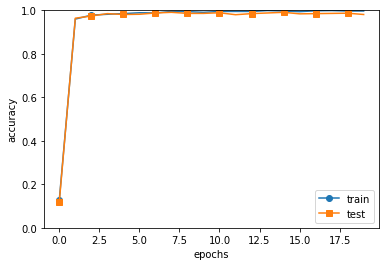

In [18]:
import matplotlib.pyplot as plt
from DLfromscratch.dataset.mnist import load_mnist
from DLfromscratch.common.trainer import Trainer
from DLfromscratch.ch07.simple_convnet import SimpleConvNet as SCN

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SCN(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
